In [2]:
# СОСНЮК КАТЕРИНА ФІТ 4-6 ВАРІАНТ 22 
# Розробити власну архітектуру GAN для датасету fashion mnist  для побудови реалістичного зображення певного типу одягу, наприклад, штанів, футболки, сукні.
# Необхідно завантажити датасет, вивести типи одягу, що містить датасет.
# Підготувати дані, підібрати кількість шарів, функції активації і тд.
# Побудувати графік функції втрат, вивести значення функції втрат. Вивести результат.

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt


(train_images, train_labels), (_, _) = fashion_mnist.load_data()
train_images = train_images[train_labels == 0]  
train_images = (train_images - 127.5) / 127.5  
train_images = np.expand_dims(train_images, axis=-1)  

img_shape = (28, 28, 1)

def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim, activation='relu'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512, activation='relu'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    return model


def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

latent_dim = 100
generator = build_generator(latent_dim)

gan_input = Input(shape=(latent_dim,))
fake_img = generator(gan_input)

discriminator.trainable = False

gan_output = discriminator(fake_img)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))


C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [3]:

def generate_latent_points(latent_dim, batch_size):
    return np.random.normal(0, 1, (batch_size, latent_dim))

def generate_fake_images(generator, latent_dim, batch_size):
    latent_points = generate_latent_points(latent_dim, batch_size)
    return generator.predict(latent_points)

def plot_generated_images(epoch, generator, latent_dim, examples=10, dim=(1, 10), figsize=(10, 1)):
    generated_imgs = generate_fake_images(generator, latent_dim, examples)
    generated_imgs = generated_imgs * 0.5 + 0.5  
    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_imgs[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'gan_generated_image_epoch_{epoch}.png')
    plt.show()



def train_gan(generator, discriminator, gan, train_images, latent_dim, epochs, batch_size=128):
    d_losses, g_losses = [], []
    batch_count = train_images.shape[0] // batch_size
    for epoch in range(1, epochs + 1):
        epoch_d_loss, epoch_g_loss = 0, 0
        for batch in range(batch_count):
            real_imgs = train_images[np.random.randint(0, train_images.shape[0], batch_size)]
            real_labels = np.ones((batch_size, 1))
            fake_imgs = generate_fake_images(generator, latent_dim, batch_size)
            fake_labels = np.zeros((batch_size, 1))
            
            imgs = np.concatenate([real_imgs, fake_imgs])
            labels = np.concatenate([real_labels, fake_labels])
            d_loss = discriminator.train_on_batch(imgs, labels)
            epoch_d_loss += d_loss[0]
            
            misleading_targets = np.ones((batch_size, 1))
            g_loss = gan.train_on_batch(generate_latent_points(latent_dim, batch_size), misleading_targets)
            epoch_g_loss += g_loss
            
        epoch_d_loss /= batch_count
        epoch_g_loss /= batch_count
        d_losses.append(epoch_d_loss)
        g_losses.append(epoch_g_loss)
    
        print(f"Epoch {epoch}/{epochs}, D loss: {epoch_d_loss:.4f}, G loss: {epoch_g_loss:.4f}")
    
    return d_losses, g_losses

def plot_losses(d_losses, g_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label='Discriminator loss')
    plt.plot(g_losses, label='Generator loss')
    plt.title('Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:77: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━

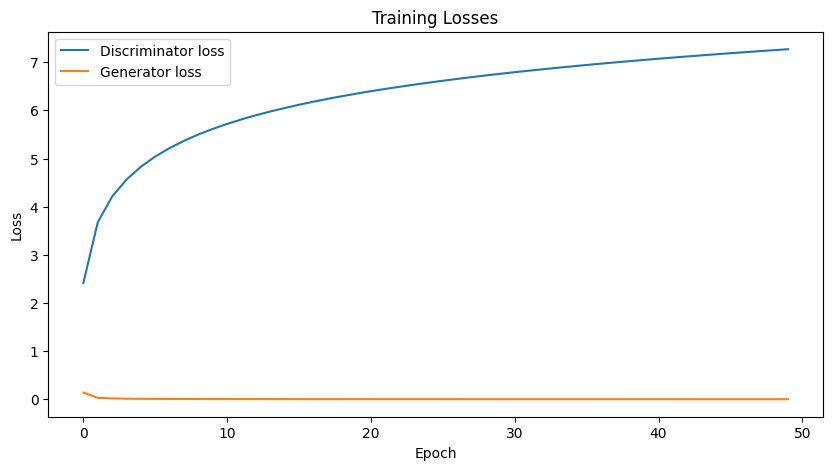

In [4]:

epochs = 50
batch_size = 128
d_losses, g_losses = train_gan(generator, discriminator, gan, train_images, latent_dim, epochs, batch_size)
plot_losses(d_losses, g_losses)

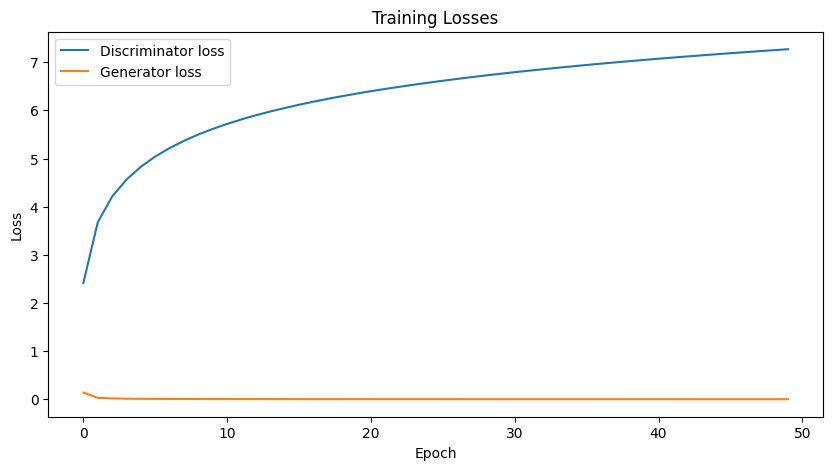

In [5]:
#ДЛЯ ЗРУЧНОСТІ ВИВОДИМО РЕЗУЛЬТАТИ ОКРЕМО
plot_losses(d_losses, g_losses)